## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Citation of this work is required in derivative works:

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

The RML2016.10a dataset is used for this work (https://radioml.com/datasets/)


In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline

import os
os.environ["KERAS_BACKEND"] = "theano"
# os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)

import keras.models as models
from keras.layers import Reshape,Dense,Dropout,Activation,Flatten
# from keras.layers.noise import GaussianNoise
from keras.layers import Convolution2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import Adam
import keras
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np

2023-09-17 16:31:16.010158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Dataset setup

In [2]:
# Load the dataset ...
#  You will need to seperately download or generate this file
with open(r'../../RML2016.10a_dict.pkl', 'rb') as p_f:
    Xd = pickle.load(p_f, encoding="latin-1")
    
snrs, mods = map(lambda j: sorted(
    list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod, snr)])
        lbl.extend((mod, snr) for _ in range(Xd[(mod, snr)].shape[0]))

X = np.vstack(X) 

In [3]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy = list(yy)
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

In [4]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


# Build the NN Model

In [5]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5  # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1] + in_shp, input_shape=in_shp))
model.add(ZeroPadding2D(padding=(0, 2), data_format='channels_first')) 
model.add(Convolution2D(256, (1, 3), padding='valid',
          activation='relu', name='conv1', data_format='channels_first'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2), data_format='channels_first'))
model.add(Convolution2D(80, (2, 3), padding='valid',
          activation='relu', name='conv2', data_format='channels_first'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu',
          kernel_initializer='he_normal', name='dense1'))
model.add(Dropout(dr))
model.add(Dense(len(classes), kernel_initializer='he_normal', name='dense2'))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

2023-09-17 16:31:19.494491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 16:31:19.520035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 16:31:19.523368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 1, 2, 132)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 256, 2, 130)       1024      
                                                                 
 dropout (Dropout)           (None, 256, 2, 130)       0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 256, 2, 134)      0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 80, 1, 132)        1

In [6]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [7]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    verbose=2,
                    validation_data=(X_test, Y_test),
                    callbacks=[
                        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                                        mode='auto'),
                        keras.callbacks.EarlyStopping(
                            monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


2023-09-17 16:31:20.567252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-09-17 16:31:21.037271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-17 16:31:21.062232: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f341d4359b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-17 16:31:21.062258: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2023-09-17 16:31:21.066996: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-17 16:31:21.166582: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

108/108 - 12s - loss: 2.2394 - val_loss: 2.0853 - 12s/epoch - 114ms/step
Epoch 2/100
108/108 - 8s - loss: 2.0072 - val_loss: 1.8873 - 8s/epoch - 78ms/step
Epoch 3/100
108/108 - 8s - loss: 1.8727 - val_loss: 1.7695 - 8s/epoch - 79ms/step
Epoch 4/100
108/108 - 9s - loss: 1.7740 - val_loss: 1.6680 - 9s/epoch - 79ms/step
Epoch 5/100
108/108 - 9s - loss: 1.6928 - val_loss: 1.5934 - 9s/epoch - 79ms/step
Epoch 6/100
108/108 - 9s - loss: 1.6341 - val_loss: 1.5425 - 9s/epoch - 80ms/step
Epoch 7/100
108/108 - 9s - loss: 1.5833 - val_loss: 1.4835 - 9s/epoch - 80ms/step
Epoch 8/100
108/108 - 9s - loss: 1.5440 - val_loss: 1.4429 - 9s/epoch - 79ms/step
Epoch 9/100
108/108 - 9s - loss: 1.4976 - val_loss: 1.3992 - 9s/epoch - 80ms/step
Epoch 10/100
108/108 - 9s - loss: 1.4643 - val_loss: 1.3698 - 9s/epoch - 79ms/step
Epoch 11/100
108/108 - 9s - loss: 1.4408 - val_loss: 1.3571 - 9s/epoch - 79ms/step
Epoch 12/100
108/108 - 9s - loss: 1.4195 - val_loss: 1.3252 - 9s/epoch - 79ms/step
Epoch 13/100
108/108 -

# Evaluate and Plot Model Performance

In [8]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test)
print(score)

3438/3438 [==============================] - 5s 1ms/step - loss: 1.2739
1.2738608121871948


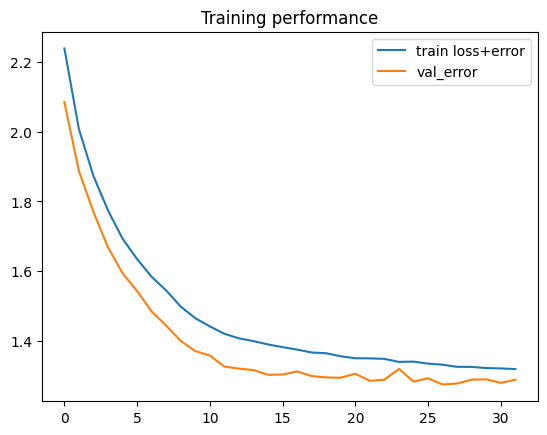

In [9]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [10]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

108/108 [==============================] - 2s 19ms/step


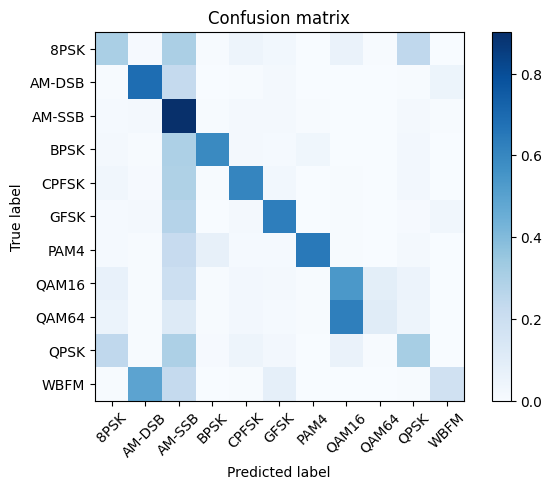

In [11]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



171/171 [==============================] - 0s 1ms/step
Overall Accuracy:  0.0969807868252516
173/173 [==============================] - 0s 1ms/step
Overall Accuracy:  0.09118982742960945
173/173 [==============================] - 0s 1ms/step
Overall Accuracy:  0.0920767004341534
174/174 [==============================] - 0s 1ms/step
Overall Accuracy:  0.10664020209310718
172/172 [==============================] - 0s 2ms/step
Overall Accuracy:  0.12871467639015496
176/176 [==============================] - 0s 2ms/step
Overall Accuracy:  0.20330549138084236
171/171 [==============================] - 0s 1ms/step
Overall Accuracy:  0.3154510380304979
171/171 [==============================] - 0s 850us/step
Overall Accuracy:  0.4803885630498534
170/170 [==============================] - 0s 1ms/step
Overall Accuracy:  0.5939001848428835
173/173 [==============================] - 0s 1ms/step
Overall Accuracy:  0.6676342525399129
172/172 [==============================] - 0s 1ms/step
Overall A

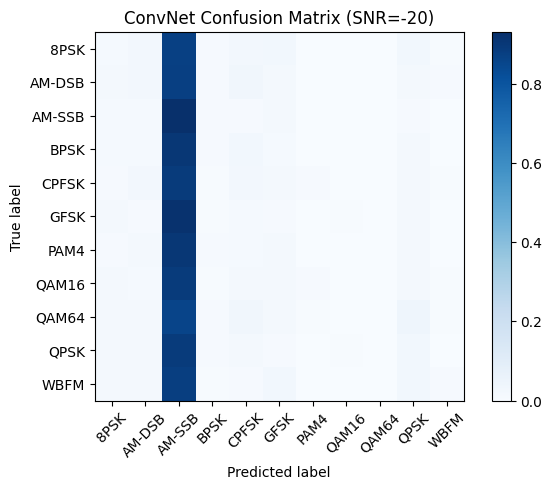

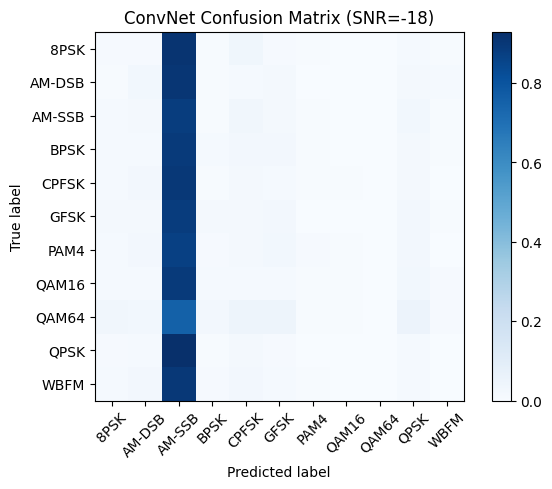

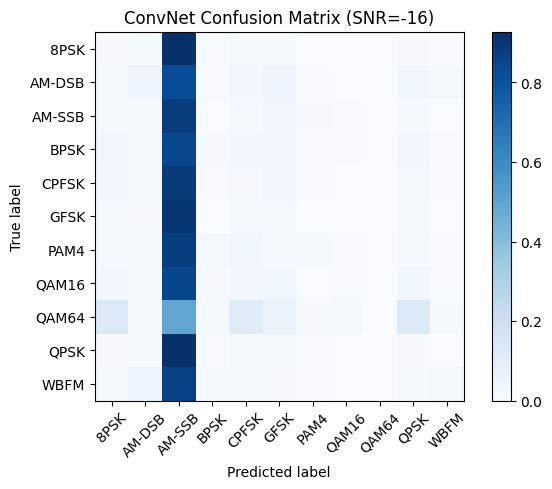

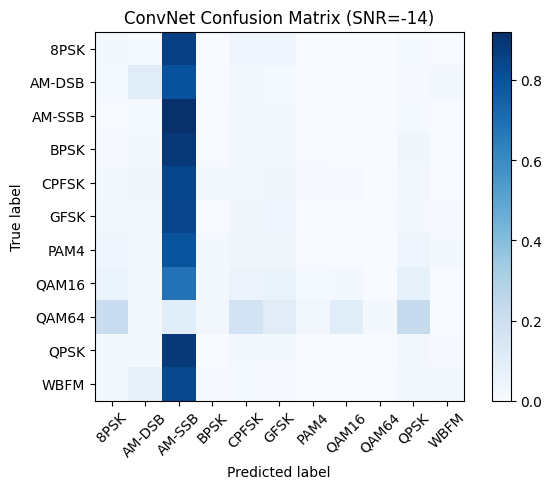

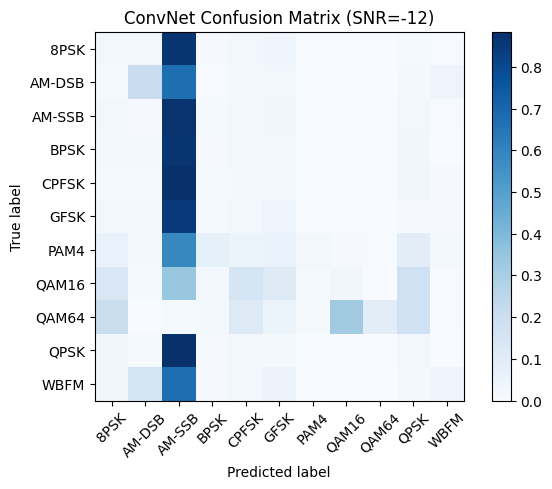

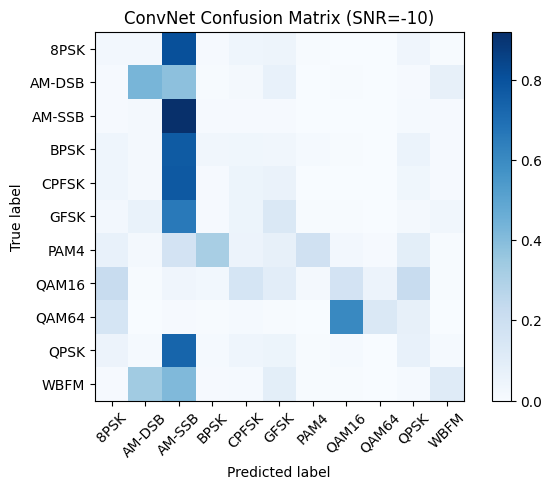

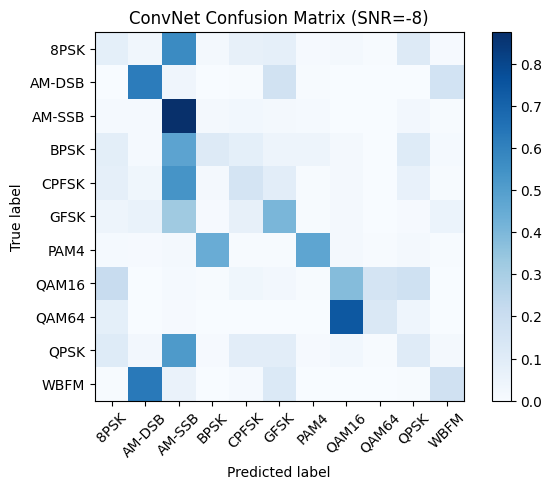

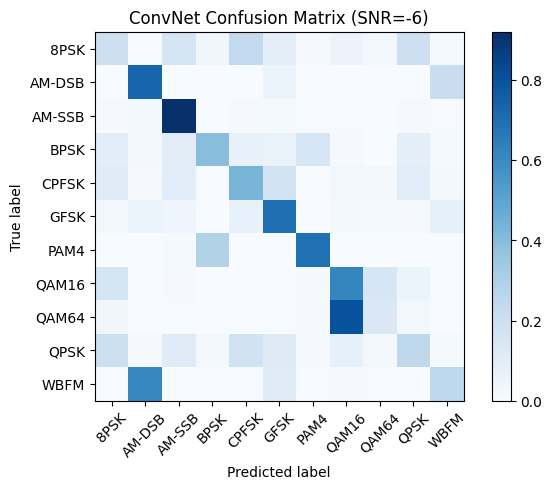

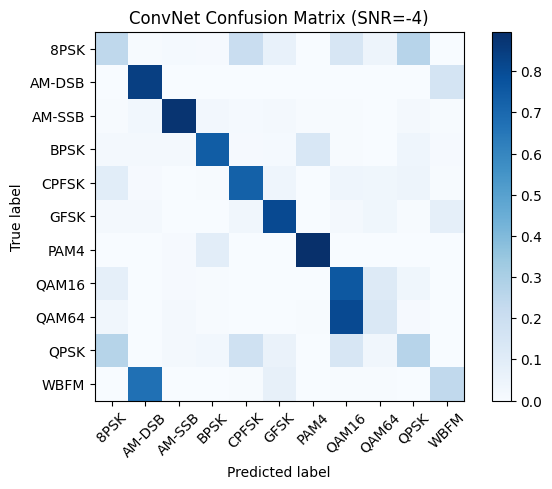

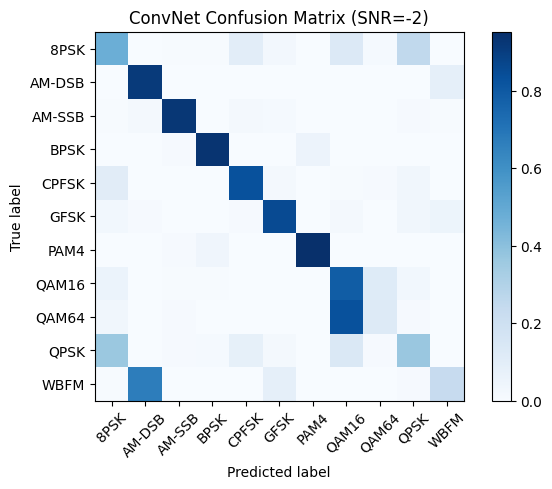

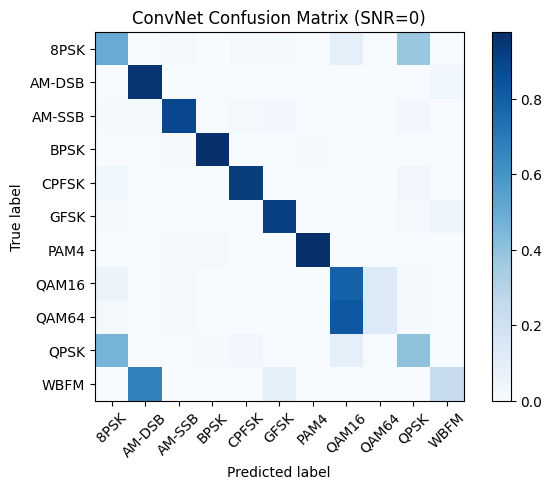

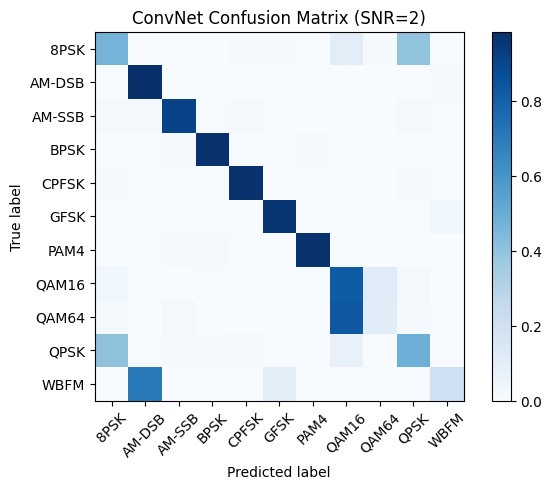

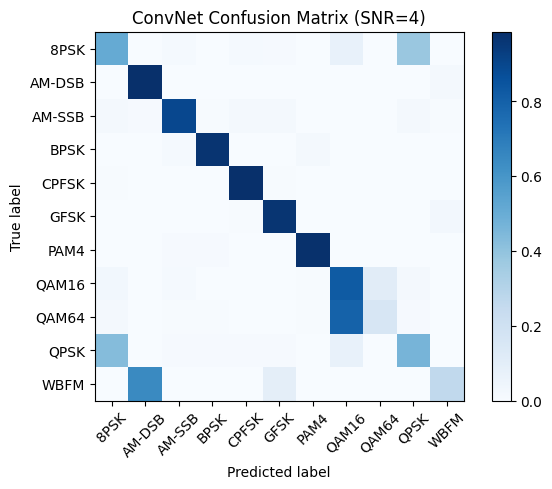

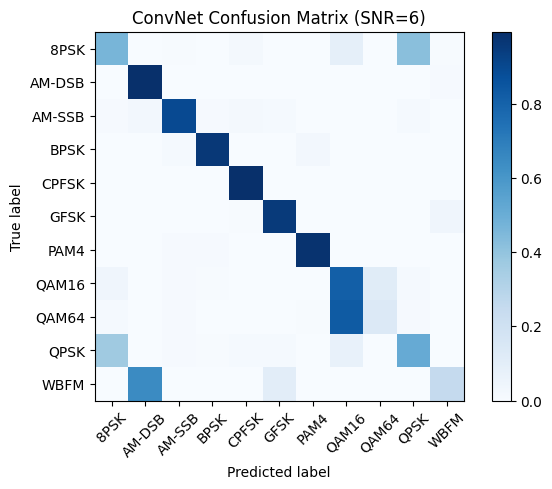

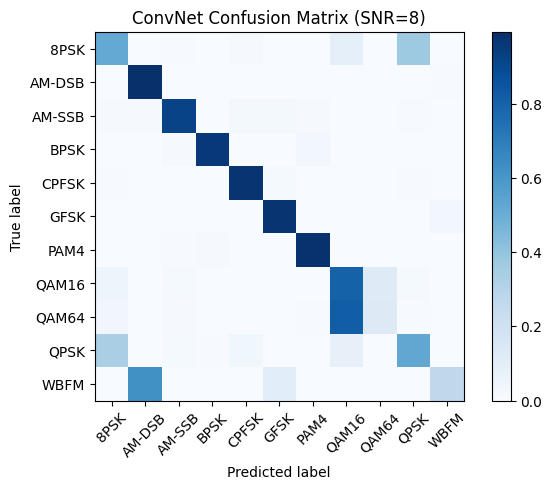

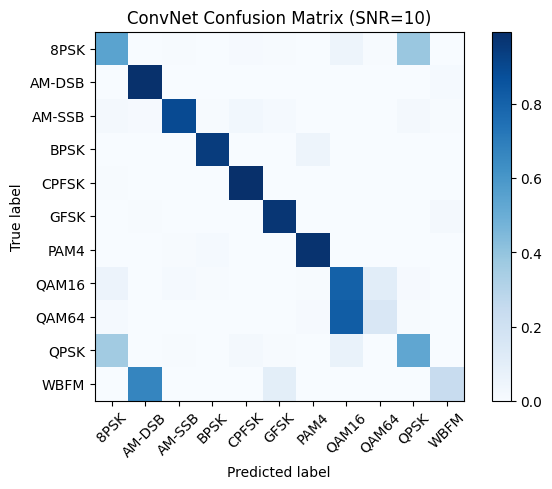

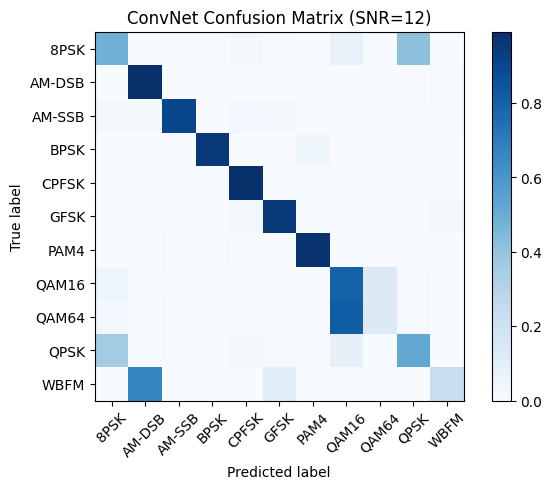

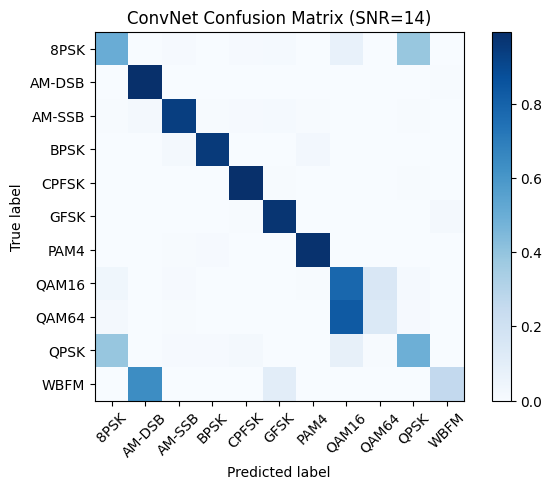

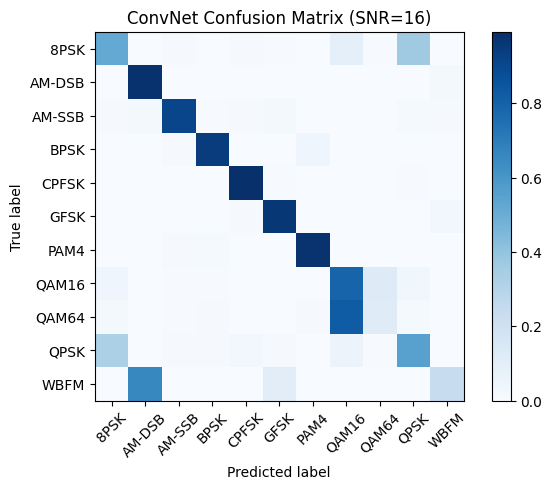

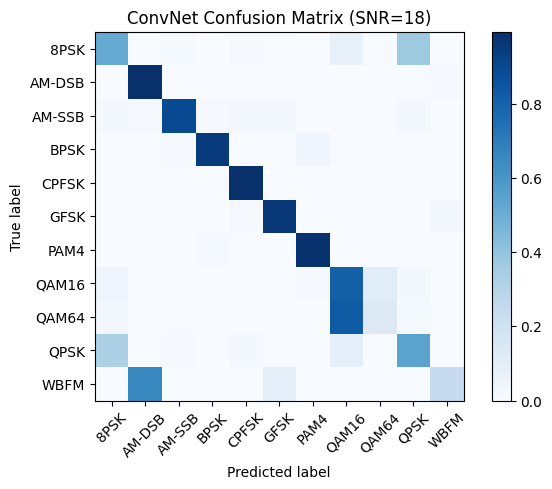

In [12]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = np.array(list(map(lambda x: lbl[x][1], test_idx)))
    test_X_i = X_test[np.where(test_SNRs == snr)]
    test_Y_i = Y_test[np.where(test_SNRs == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes,
                          title="ConvNet Confusion Matrix (SNR=%d)" % (snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [13]:
# Save results to a pickle file for plotting later
print(acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.0969807868252516, -18: 0.09118982742960945, -16: 0.0920767004341534, -14: 0.10664020209310718, -12: 0.12871467639015496, -10: 0.20330549138084236, -8: 0.3154510380304979, -6: 0.4803885630498534, -4: 0.5939001848428835, -2: 0.6676342525399129, 0: 0.69507299270073, 2: 0.7119229371137769, 4: 0.7272393538913363, 6: 0.7216606498194946, 8: 0.7311091073038773, 10: 0.7307832422586521, 12: 0.719536483795039, 14: 0.7195054438088209, 16: 0.7239819004524887, 18: 0.7285328532853286}


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

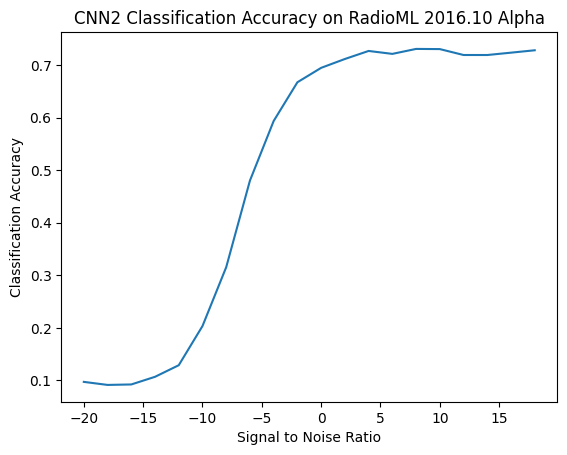

In [14]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")